In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time, sys
from IPython.display import clear_output, display
from time import sleep
import random

# Classes

In [2]:
class ImageUtil:
    
    @staticmethod
    def show1(image, title):
        fig = plt.figure()
        plt.title(title)
        plt.axis('off')
        (h, w, *c) = image.shape
        image_abs = np.abs(image)
        if(len(c) > 0):
            image_abs = cv2.cvtColor(image_abs, cv2.COLOR_BGR2RGB)
            plt.imshow(image_abs)
        else:
            plt.imshow(image_abs, cmap = 'gray')
            
    @staticmethod
    def show(images_arr, titles_arr, qs=4):
        images = np.array(images_arr)
        titles = np.array(titles_arr)
        (n_y, n_x, *rest) = images.shape
        figsize = qs * n_x, qs * n_y
        fig = plt.figure(figsize=figsize)
        plt.axis('off')
        for yy in range(n_y):
            for xx in range(n_x):
                fig.add_subplot(n_y, n_x, yy * n_x + xx + 1)
                plt.title(titles[yy, xx])
                plt.axis('off')
                (h, w, *c) = images[yy, xx].shape
                img_abs = np.abs(images[yy, xx])
                if(len(c) > 0):
                    img_abs = cv2.cvtColor(img_abs, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_abs)
                else:
                    plt.imshow(img_abs, cmap = 'gray')

In [3]:
class ProgressBar:
    
    bar_length = 20
    
    def __init__(self, title='Progress'):
        self.title = title
        progress = 0
        block = int(round(self.bar_length * progress))
        text = "{0}: [{1}] {2:.1f}%".format(self.title, "#" * block + "-" * (self.bar_length - block), progress * 100)
        self.disp = display(text, display_id=True)
        
    def update(self, progress):
        bar_length = 20
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
        block = int(round(bar_length * progress))
        text = "{0}: [{1}] {2:.1f}%".format(self.title, "#" * block + "-" * (bar_length - block), progress * 100)
        self.disp.update(text)

In [4]:
class Image:
    
    def __init__(self, bgr_image, image_size):
        self.image_size = image_size
        self.image = cv2.resize(bgr_image, (image_size, image_size))
        
    def get_y(self):
        image_ycrcb = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCrCb)
        return image_ycrcb[:, :, 0]
    
    def set_y(self, image_y):
        image_ycrcb = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCrCb)
        image_y = np.abs(image_y).astype(np.uint8)
        image_ycrcb[:, :, 0] = image_y
        self.image = cv2.cvtColor(image_ycrcb, cv2.COLOR_YCrCb2BGR)
        
    @staticmethod
    def copy(instance):
        return Image(np.copy(instance.image), instance.image_size)

In [5]:
class Logo:
    
    def __init__(self, logo, logo_size):
        logo = cv2.resize(logo, (logo_size, logo_size))
        self.logo = (logo >= 128) * 1
        self.logo_size = logo_size


In [6]:
class PHT:
    
    def __init__(self, image_size, max_momen, i_step, t_step):
        self.image_size = image_size
        self.max_momen = max_momen
        self.t_step = int(t_step)
        self.i_step = int(i_step)
        
    def pcet(self, image_bgr):

        pb = ProgressBar('Transform PCET')
        t_len = 2 * self.max_momen + 1

        im_vec = np.reshape(np.array(image_bgr), (self.image_size * self.image_size, 1))
        transformed = np.array([])

        # GENERATE MATRIX TRANSFORM

        vec_n = np.ones((t_len, t_len), dtype='float32')
        vec_m = np.ones((t_len, t_len), dtype='float32')
        for i in range(-self.max_momen, self.max_momen + 1):
            vec_n[i + self.max_momen, :] = i
            vec_m[:, i + self.max_momen] = i
        vec_n = vec_n.reshape((t_len * t_len, 1))
        vec_m = vec_m.reshape((t_len * t_len, 1))

        vec_i = np.ones((self.image_size, self.image_size), dtype='float32')
        vec_k = np.ones((self.image_size, self.image_size), dtype='float32')
        for i in range(self.image_size):
            vec_i[i, :] = i
            vec_k[:, i] = i
        vec_i = vec_i.reshape((1, self.image_size * self.image_size))
        vec_k = vec_k.reshape((1, self.image_size * self.image_size))

        vec_y = self.translate_index(vec_i)
        vec_x = self.translate_index(vec_k)
        vec_r = np.sqrt(vec_x * vec_x + vec_y * vec_y)
        vec_t = np.arctan2(vec_y, vec_x)

        # FREE UP SOME MEMORY - 1
        del vec_i
        del vec_k
        del vec_y
        del vec_x

        pb.update(0)
        for row in range(int(np.ceil(t_len / self.t_step))):
            start = row * self.t_step * t_len
            end = np.min([row * self.t_step + self.t_step, t_len]) * t_len
            mat_r = np.repeat(vec_r, end - start, axis=0)
            mat_t = np.repeat(vec_t, end - start, axis=0)
            mat_n = np.repeat(vec_n[start:end, :], self.image_size * self.image_size, axis=1)
            mat_m = np.repeat(vec_m[start:end, :], self.image_size * self.image_size, axis=1)
            mat_c = (mat_r <= 1)
            mat_f = (np.abs(mat_n) + np.abs(mat_m) <= self.max_momen)

            multiplier = 4 / (np.pi * self.image_size * self.image_size)
            mat_w = mat_f * mat_c * multiplier * np.exp(-2 * np.pi * mat_n * mat_r * mat_r * 1j - mat_m * mat_t * 1j)
            trf_row = np.matmul(mat_w, im_vec)
            transformed = np.append(transformed, trf_row)

            # FREE UP SOME MEMORY - 2
            del mat_w
            del mat_n
            del mat_m
            del mat_r
            del mat_t
            del mat_c
            del mat_f

            pb.update((row * self.t_step + self.t_step) / t_len)

        pb.update(1)

        transformed2 = np.reshape(transformed, (t_len, t_len))
        del transformed
        return transformed2
    
    def inverse_pcet(self, momen):

        pb = ProgressBar('Inverse PCET')
        t_len = 2 * self.max_momen + 1

        momen_vec = np.reshape(np.array(momen), (t_len * t_len, 1))
        inversed = np.array([])

        # GENERATE MATRIX INVERS TRANSFORM

        vec_n = np.ones((t_len, t_len), dtype='float32')
        vec_m = np.ones((t_len, t_len), dtype='float32')
        for i in range(-self.max_momen, self.max_momen + 1):
            vec_n[i + self.max_momen, :] = i
            vec_m[:, i + self.max_momen] = i
        vec_n = vec_n.reshape((1, t_len * t_len))
        vec_m = vec_m.reshape((1, t_len * t_len))

        vec_i = np.ones((self.image_size, self.image_size), dtype='float32')
        vec_k = np.ones((self.image_size, self.image_size), dtype='float32')
        for i in range(self.image_size):
            vec_i[i,:] = i
            vec_k[:,i] = i
        vec_i = vec_i.reshape((self.image_size * self.image_size, 1))
        vec_k = vec_k.reshape((self.image_size * self.image_size, 1))

        vec_y = self.translate_index(vec_i)
        vec_x = self.translate_index(vec_k)
        vec_r = np.sqrt(vec_x * vec_x + vec_y * vec_y)
        vec_t = np.arctan2(vec_y, vec_x)

        # FREE UP SOME MEMORY - 1
        del vec_i
        del vec_k
        del vec_y
        del vec_x

        pb.update(0)
        for row in range(int(np.ceil(self.image_size / self.i_step))):
            start = row * self.i_step * self.image_size
            end = np.min([row * self.i_step + self.i_step, self.image_size]) * self.image_size
            mat_r = np.repeat(vec_r[start:end, :], t_len * t_len, axis=1)
            mat_t = np.repeat(vec_t[start:end, :], t_len * t_len, axis=1)
            mat_n = np.repeat(vec_n, end - start, axis=0)
            mat_m = np.repeat(vec_m, end - start, axis=0)
            mat_c = (mat_r <= 1)
            mat_f = (np.abs(mat_n) + np.abs(mat_m) <= self.max_momen)

            mat_v = mat_f * mat_c * np.exp(2 * np.pi * mat_n * mat_r * mat_r * 1j + mat_m * mat_t * 1j)
            inv_row = np.matmul(mat_v, momen_vec)
            inversed = np.append(inversed, inv_row)

            # FREE UP SOME MEMORY - 2
            del mat_v
            del mat_n
            del mat_m
            del mat_r
            del mat_t
            del mat_c
            del mat_f

            pb.update((row * self.i_step + self.i_step) / self.image_size)

        pb.update(1)

        inversed2 = np.reshape(inversed, (self.image_size, self.image_size))
        del inversed
        return inversed2
    
    def translate_index(self, index):
        return (2 * index - self.image_size + 1) / self.image_size

In [7]:
class RIW:
    
    def __init__(self, image, logo, max_momen, q_step, batch=10):
        self.image = image
        self.logo = logo
        self.max_momen = max_momen
        self.q_step = q_step
        self.batch = batch
        
    def embed(self):
        image_size = self.image.image_size
        logo_size = self.logo.logo_size
        
        # Transform Image
        transformer = PHT(image_size, self.max_momen, image_size/self.batch/2, self.max_momen/self.batch)
        self.momen = transformer.pcet(self.image.get_y())
        
        # Momen Selection
        accurate_momen = np.array([])
        for n in range(2 * self.max_momen + 1):
            order = n - self.max_momen
            for m in range(2 * self.max_momen + 1):
                repetition = m - self.max_momen
                if(self.is_accurate(order, repetition)):
                    accurate_momen = np.append(accurate_momen, self.momen[n, m])
        
        # Embed Data
        logo_flatten = self.logo.logo.flatten()
        if(len(logo_flatten) > len(accurate_momen)):
            print("Error, use bigger max_momen!")
            return
        
        selected_index = self.generate_random_index(len(logo_flatten), 0, len(accurate_momen) - 1)
        current_momen = np.array([])
        for i in range(len(selected_index)):
            current_momen = np.append(current_momen, accurate_momen[selected_index[i]])
        
        expected_momen = 2 * self.q_step * np.round(np.abs(current_momen) / 2 / self.q_step)
        expected_momen = expected_momen + self.q_step / 2 * (logo_flatten == 1)
        expected_momen = expected_momen - self.q_step / 2 * (logo_flatten == 0)
        expected_momen = expected_momen + 2 * self.q_step * (expected_momen < 0)
        
        diff_momen = expected_momen - np.abs(current_momen)
        diff_momen = diff_momen / (np.abs(current_momen) + 0.000000001) * current_momen
        
        # Generate Compensation Momen
        new_accurate_momen = np.zeros(len(accurate_momen), dtype='complex128')
        for i in range(len(selected_index)):
            new_accurate_momen[selected_index[i]] = diff_momen[i]
        
        self.compensation_momen = np.zeros((2 * self.max_momen + 1, 2 * self.max_momen + 1), dtype='complex128')
        index = 0
        for n in range(2 * self.max_momen + 1):
            order = n - self.max_momen
            for m in range(2 * self.max_momen + 1):
                repetition = m - self.max_momen
                if(self.is_accurate(order, repetition)):
                    self.compensation_momen[n, m] = new_accurate_momen[index]
                    index = index + 1
        self.compensation_momen = self.compensation_momen + np.rot90(np.rot90(self.compensation_momen))
        
        self.compensation_image = transformer.inverse_pcet(self.compensation_momen)
        self.w_image = Image.copy(self.image)
        self.w_image.set_y(self.w_image.get_y() + self.compensation_image)
        
    def extract(self):
        image_size = self.image.image_size
        logo_size = self.logo.logo_size
        
        # Transform Image
        transformer = PHT(image_size, self.max_momen, image_size/self.batch/2, self.max_momen/self.batch)
        momen = transformer.pcet(self.w_image.get_y())
        
        # Momen Selection
        accurate_momen = np.array([])
        for n in range(2 * self.max_momen + 1):
            order = n - self.max_momen
            for m in range(2 * self.max_momen + 1):
                repetition = m - self.max_momen
                if(self.is_accurate(order, repetition)):
                    accurate_momen = np.append(accurate_momen, momen[n, m])
        
        # Extract Logo
        selected_index = self.generate_random_index(logo_size * logo_size, 0, len(accurate_momen) - 1)
        current_momen = np.array([])
        for i in range(len(selected_index)):
            current_momen = np.append(current_momen, accurate_momen[selected_index[i]])
        
        logo_flatten = ((np.abs(current_momen) - 2 * self.q_step * np.round(np.abs(current_momen) / 2 / self.q_step)) > 0) * 1
        logo_extracted = logo_flatten.reshape((logo_size, logo_size))
        ImageUtil.show1(logo_extracted, 'Exctracted Watermark')
        
    def is_accurate(self, order, repetition):
        return (
            repetition % 4 != 0 and
            np.abs(order) + np.abs(repetition) <= self.max_momen and
            order > 0
        )
    
    @staticmethod
    def generate_random_index(array_size, min_val, max_val):
        if(array_size > max_val - min_val):
            print("Error, array_size ({}) bigger than range ({})!".format(array_size, max_val - min_val))
            return np.array([])
        
        random.seed(10)
        arr = np.array([])
        for i in range(array_size):
            val = random.randint(min_val, max_val)
            while(val in arr):
                val = random.randint(min_val, max_val)
            arr = np.append(arr, val)
        
        return arr.astype(int)

In [8]:
class AntiTranslation:

    @staticmethod
    def kp2pt(kp):
        (px, py) = kp.pt
        return (int(px), int(py))

    @classmethod
    def get_pairs(cls, keypointmathces, keypoints1, keypoints2):
        pairs = []
        for mt in keypointmathces:
            p1 = keypoints1[mt.queryIdx]
            p2 = keypoints2[mt.trainIdx]
            pairs.append((cls.kp2pt(p1), cls.kp2pt(p2)))
        return pairs

    @staticmethod
    def calc_dist(pa, pb):
        (pax, pay) = pa
        (pbx, pby) = pb
        dx = pax - pbx
        dy = pay - pby
        return np.sqrt(dx * dx + dy * dy)

    @staticmethod
    def add_tupple(t1, t2):
        (t1x, t1y) = t1
        (t2x, t2y) = t2
        return (t1x + t2x, t1y + t2y)

    @classmethod
    def calc_error(cls, keypointmathces, keypoints1, keypoints2, center1, center2, s):
        pairs = cls.get_pairs(keypointmathces, keypoints1, keypoints2)
        sum = 0
        for (p1, p2) in pairs:
            d1 = cls.calc_dist(p1, center1)
            d2 = s * cls.calc_dist(p2, center2)
            sum += abs(d1 - d2)
        return sum / len(pairs)
    
    @classmethod
    def optimize_center(cls, keypointmathces, keypoints1, keypoints2, c1, c2):
        dx = 0
        dy = 0
        s = 1
        d_step = 0.1
        s_step = 0.01
        N_STEP = 2000

        err = 10000

        pb = ProgressBar('Calculate Center')
        for i in range(N_STEP):

            update_variable = [
                (0, dx + d_step, dy + d_step, s + s_step),
                (0, dx + d_step, dy + d_step, s),
                (0, dx + d_step, dy + d_step, s - s_step),
                
                (0, dx + d_step, dy - d_step, s + s_step),
                (0, dx + d_step, dy - d_step, s),
                (0, dx + d_step, dy - d_step, s - s_step),
                
                (0, dx - d_step, dy + d_step, s + s_step),
                (0, dx - d_step, dy + d_step, s),
                (0, dx - d_step, dy + d_step, s - s_step),
                
                (0, dx - d_step, dy - d_step, s + s_step),
                (0, dx - d_step, dy - d_step, s),
                (0, dx - d_step, dy - d_step, s - s_step),
            ]

            for j in range(len(update_variable)):
                (_, updated_x, updated_y, updated_s) = update_variable[j]
                tmp = cls.calc_error(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + updated_x, c2 + updated_y), updated_s)
                update_variable[j] = (tmp, update_variable[j][1], update_variable[j][2], update_variable[j][3])

            update_variable = sorted(update_variable, key=lambda tup: tup[0])

            err = update_variable[0][0]
            dx = update_variable[0][1]
            dy = update_variable[0][2]
            s = update_variable[0][3]

            pb.update(i / N_STEP)

        pb.update(1)
        return (int(np.round(-dx)), int(np.round(-dy)), s)
    
    @classmethod
    def calculate_center(cls, original, attacked):
    
        # Initiate ORB detector
        orb = cv2.ORB_create()

        # find the keypoints and descriptors with ORB
        kp_1, des_1 = orb.detectAndCompute(original,None)
        kp_2, des_2 = orb.detectAndCompute(attacked,None)

        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.
        matches = bf.match(des_1, des_2)

        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)

        (n1, *_) = original.shape
        (n2, *_) = attacked.shape

        return cls.optimize_center(matches[:50], kp_1, kp_2, (n1 - 1) / 2, (n2 - 1) / 2)

# Implementation

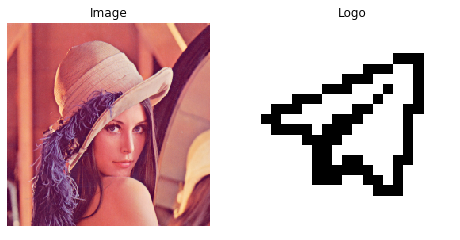

In [9]:
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

my_image = Image(ori_img, 200)
my_logo = Logo(ori_logo, 20)

ImageUtil.show([[my_image.image, my_logo.logo]], [['Image', 'Logo']])

'Transform PCET: [####################] 100.0%'

'Inverse PCET: [####################] 100.0%'

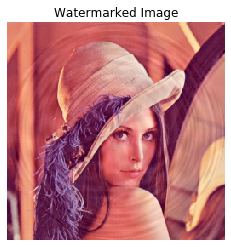

In [10]:
riw = RIW(my_image, my_logo, 24, 0.5, 4)
riw.embed()
ImageUtil.show1(riw.w_image.image, 'Watermarked Image')

'Transform PCET: [####################] 100.0%'

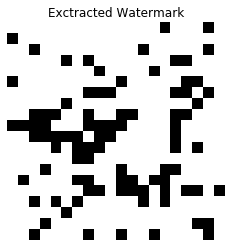

In [11]:
riw.extract()

'Calculate Center: [####################] 100.0%'

(-9, -6, 1.0)

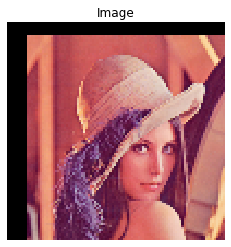

In [85]:
n = 100
dx = 6
dy = 9
img1 = Image(ori_img, n)

img2 = np.zeros(img1.image.shape).astype('uint8')
img2[dx:n, dy:n, :] = img1.image[0:n-dx, 0:n-dy, :]

ImageUtil.show1(img2, 'Image')

AntiTranslation.calculate_center(img1.image, img2)

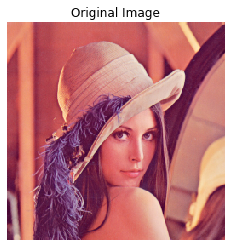

In [27]:
my_image = Image(ori_img, 256)
ImageUtil.show1(my_image.image, 'Original Image')

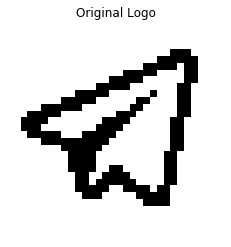

In [28]:
my_logo = Logo(ori_logo, 32)
ImageUtil.show1(my_logo.logo, 'Original Logo')

'Transform PCET: [####################] 100.0%'

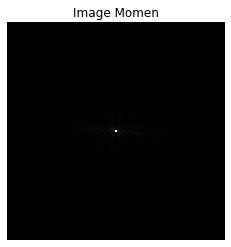

In [25]:
transformer = PHT(256, 42, 256/4, 32/2)
momen = transformer.pcet(my_image.get_y())
ImageUtil.show1(momen, 'Image Momen')

'Inverse PCET: [####################] 100.0%'

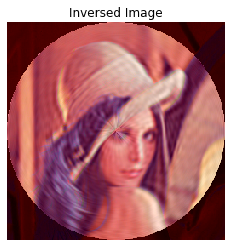

In [26]:
inversed_image = Image.copy(my_image)
inversed_image.set_y(transformer.inverse_pcet(momen))
ImageUtil.show1(inversed_image.image, 'Inversed Image')

In [39]:
random.seed(5)
arr = np.array([])
for i in range(20):
    val = random.randint(0, 20)
    while(val in arr):
        val = random.randint(0, 20)
    arr = np.append(arr, val) 
arr

array([19.,  8., 11., 20., 16.,  0., 14.,  7.,  1.,  5.,  3., 15., 12.,
       17., 18.,  6., 13.,  2.,  4.,  9.])